In [ ]:
!pip3 install torchsummary
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchtext --upgrade
!pip3 install fastai --upgrade

In [2]:
import os
import pandas as pd
from torch.utils.data import Dataset,Subset
from torchvision import transforms,models,datasets
import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import shutil

In [13]:
os.chdir('C:/Local Machine/Cassava plant disease detection')

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download cassava-leaf-disease-classification -f train.csv
!kaggle competitions download cassava-leaf-disease-classification -f label_num_to_disease_map.json
url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13836/1718836/compressed/train_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1632816375&Signature=ZcHK%2ByVWK%2BksI9Ab6P2skLxtp6wFT6X4xHG9mcER3C4lBYjk9q7JXP6pF7G4OJJ%2FFiHYNhLTq7LibgS8LyurmQYWSPCAHpPiNIkeTYEG44gLBKH4Qx3IrXyMQ1WK4mmh%2BhUtjOMJqAYQp85dcXsYScwP2ipXmiU8pOoWOf%2BZPQFuGpr2yMCImJk%2FAdOEaiZhvr4AmMwKUpBJ82lc4YlTTmblqpPIPpDE9ZGrKiSDLwtEfbLykXrw%2Fxc9fuMvGGivxs3nfJt3vJddoPCU2EwQRBnaRwKr4KtKYo3ljvVZ4ELDwIIEEb9BAFEi9OHMNx%2Fb6vX6SgD59tjXwYMaPmEIWw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain_images.zip'
!pip install wget
import wget
wget.download(url, 'train.zip')
import zipfile as zf
file0 = zf.ZipFile('train.zip')
file0.extractall('train_images')
#!kaggle competitions download cassava-leaf-disease-classification -f train_images -p train_images

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  Created wheel for wg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: ignored

In [ ]:
#os.chdir('/kaggle/input/cassava-leaf-disease-classification')
os.chdir('/content')      

In [4]:
# LOAD THE DATASET
train_df = pd.read_csv('train.csv')
train_label = train_df.copy()
# GET THE IMAGE ID NUMBER
label_names = ['Cassava Bacterial Blight (CBB)','Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']
label_nums = []
number_of_class = [0,0,0,0,0]
for i in train_label['label']:
  t = int(i)
  number_of_class[int(i)] = number_of_class[int(i)] + 1
  label_nums.append(label_names[t])
train_label['disease'] = label_nums
train_label['label'] = train_label['label'].astype(str)
print(train_label.shape)
print(f"number of data's in each class :{number_of_class}")
print(train_label.head())

(21397, 3)
number of data's in each class :[1087, 2189, 2386, 13158, 2577]
         image_id label                              disease
0  1000015157.jpg     0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg     3         Cassava Mosaic Disease (CMD)
2   100042118.jpg     1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg     1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg     3         Cassava Mosaic Disease (CMD)


In [5]:
class PathologyPlantsDataset(Dataset):  #  <--- جنس پارامتر ورودی از نوع دیتاست برگرفته از کتابخانه دیتاست پایتورچ می باشد
  """
  The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
  """
  def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
    
  def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)
    
  def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data_frame.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
    
        return (image, label)

In [6]:
# INSTANTIATE THE OBJECT
transform = transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
                                transforms.ColorJitter(brightness=.2, hue=.1),#transforms.RandomAdjustSharpness(sharpness_factor=2),
                                transforms.RandomPerspective(distortion_scale=0.4,p=0.2),
                                transforms.RandomRotation(degrees=(0,180)),#transforms.RandomAffine(),
                                transforms.ToTensor(),#transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ])
pathology_train = PathologyPlantsDataset(data_frame=train_label,root_dir='train_images',transform=transform)
print(pathology_train)

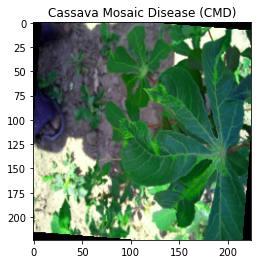

<class '__main__.PathologyPlantsDataset'>
<class 'int'>


In [7]:
temp_img, temp_lab = pathology_train[4]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title(label_names[int(temp_lab)])
#plt.title(temp_lab)
#plt.axis('off')
plt.show()
print(type(pathology_train))
print(type(temp_lab))

In [8]:
batch_size = 32   #  <------------------
validation_size = 2000
train_size = 15000
test_size = len(pathology_train) - train_size - validation_size

print("Length of Dataset : " + str(len(pathology_train)))
train_data,validation_data,test_data = random_split(pathology_train,[train_size,validation_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(validation_data)}")
print(f"Length of Test Data : {len(test_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = False, pin_memory = True)  # , pin_memory = True num_workers = 1, shuffle = True
val_dl = DataLoader(validation_data, batch_size, shuffle = False, pin_memory = True)  # , pin_memory = True num_workers = 1, shuffle = True
test_dl = DataLoader(test_data, batch_size, shuffle = False, pin_memory = True)

Length of Dataset : 21397
Length of Train Data : 15000
Length of Validation Data : 2000
Length of Test Data : 4397


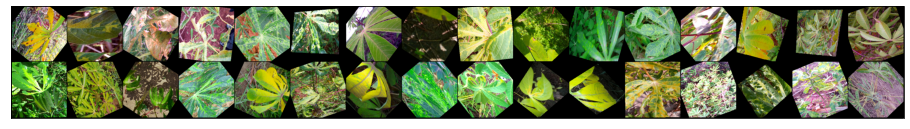

In [14]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

  
show_batch(train_dl)

In [ ]:
classifier = hub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2')

In [ ]:
model = classifier


In [10]:
targets_size = 5
model = models.resnet50(pretrained=True)
for params in model.parameters():
    params.requires_grad = True
print(model)
model.fc = nn.Linear(in_features= 2048 , out_features= 5)
"""
model.add_module('7',nn.Linear(in_features=1000, out_features=320, bias=True))
model.add_module('8',nn.ReLU())
model.add_module('9',nn.Dropout(p=0.4,inplace=True))
model.add_module('10',nn.Linear(in_features=320, out_features=80, bias=True))
model.add_module('11',nn.ReLU())
model.add_module('12',nn.Dropout(p=0.4,inplace=True))
model.add_module('13',nn.Linear(in_features=80, out_features=20, bias=True))
model.add_module('14',nn.ReLU())
model.add_module('15',nn.Dropout(p=0.4,inplace=True))
model.add_module('16',nn.Linear(in_features=20, out_features=5, bias=True))
"""

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

"\nmodel.add_module('7',nn.Linear(in_features=1000, out_features=320, bias=True))\nmodel.add_module('8',nn.ReLU())\nmodel.add_module('9',nn.Dropout(p=0.4,inplace=True))\nmodel.add_module('10',nn.Linear(in_features=320, out_features=80, bias=True))\nmodel.add_module('11',nn.ReLU())\nmodel.add_module('12',nn.Dropout(p=0.4,inplace=True))\nmodel.add_module('13',nn.Linear(in_features=80, out_features=20, bias=True))\nmodel.add_module('14',nn.ReLU())\nmodel.add_module('15',nn.Dropout(p=0.4,inplace=True))\nmodel.add_module('16',nn.Linear(in_features=20, out_features=5, bias=True))\n"

In [ ]:
torch.cuda.reset_peak_memory_stats
torch.cuda.reset_max_memory_allocated
torch.cuda.reset_max_memory_cached
torch.cuda.reset_accumulated_memory_stats
torch.cuda.empty_cache
print(torch.cuda.memory_reserved())

4506779648


In [ ]:

def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)
 
dump_tensors()

Total size: 0


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = "cuda"
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(model, (3, 224, 224))

In [16]:
weights = torch.tensor([0.0,0.0,0.0,0.0,0.0], dtype=torch.float32)
for i in range(len(number_of_class)) :
  weights[i] = number_of_class[i]
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)
weights = weights.to(device)

tensor([0.0508, 0.1023, 0.1115, 0.6149, 0.1204])
tensor([0.4071, 0.2021, 0.1855, 0.0336, 0.1717])


In [30]:
criterion = nn.CrossEntropyLoss(weight = weights)  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

In [22]:
train_losses = []
validation_losses = []

In [46]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    #np.append(arr = train_losses,values = np.zeros(epochs))
    #np.append(arr = validation_losses,values = np.zeros(epochs))
    
    
    prev_loss = 0.492
    weights.to(device)
    for e in range(epochs):
        os.chdir('C:/Local Machine/Cassava plant disease detection')
        #os.chdir('/content')    #colab
        #os.chdir('/kaggle/input/cassava-leaf-disease-classification')   #kaggle
        t0 = datetime.now()
        train_loss = []
        n_correct = 0
        n_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

            _, predictions = torch.max(output, 1)
            n_correct += (predictions == targets).sum().item()
            n_total += targets.shape[0]

        validation_loss = np.mean(validation_loss)

        #train_losses[e] = train_loss
        #validation_losses[e] = validation_loss
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        dt = datetime.now() - t0
        acc = n_correct / n_total
        #document.querySelector("#recaptcha-anchor").click()
        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Validation_loss:{validation_loss:.3f} Duration:{dt} Validation_Acc:{acc*100:.2f}"
        )

        if validation_loss < prev_loss:
          prev_loss = validation_loss
          #os.chdir('/content/drive/MyDrive')  #colab
          #os.chdir('/kaggle/working')  #kaggle
          os.chdir('C:/Local Machine/Cassava plant disease detection/...saves1')
          torch.save(model.state_dict() , 'plant_disease_model_14.pt')
          torch.save(train_dl , 'train_dl14.pth')
          torch.save(val_dl , 'val_dl14.pth')
          torch.save(test_dl , 'test_dl14.pth')
          print("model saved !")

    return train_losses, validation_losses

In [ ]:
model.train()
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 10)

Epoch : 1/10 Train_loss:1.350 Validation_loss:1.237 Duration:0:09:50.451804 Validation_Acc:57.70
Epoch : 2/10 Train_loss:1.132 Validation_loss:1.169 Duration:0:09:51.537953 Validation_Acc:60.45
Epoch : 3/10 Train_loss:1.073 Validation_loss:1.025 Duration:0:10:00.378700 Validation_Acc:67.80
Epoch : 4/10 Train_loss:1.047 Validation_loss:1.052 Duration:0:10:02.044221 Validation_Acc:66.05
Epoch : 5/10 Train_loss:1.003 Validation_loss:0.999 Duration:0:10:03.525740 Validation_Acc:70.55
Epoch : 6/10 Train_loss:0.964 Validation_loss:1.006 Duration:0:10:07.682280 Validation_Acc:68.25
Epoch : 7/10 Train_loss:0.958 Validation_loss:0.967 Duration:0:10:04.088110 Validation_Acc:71.85
Epoch : 8/10 Train_loss:0.931 Validation_loss:0.952 Duration:0:10:03.849925 Validation_Acc:71.30
Epoch : 9/10 Train_loss:0.941 Validation_loss:1.000 Duration:0:10:02.796351 Validation_Acc:67.10
Epoch : 10/10 Train_loss:0.926 Validation_loss:0.984 Duration:0:10:04.155972 Validation_Acc:69.10


In [ ]:
model.train()
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 10)

Epoch : 1/10 Train_loss:0.909 Validation_loss:0.930 Duration:0:10:06.242570 Validation_Acc:71.90
Epoch : 2/10 Train_loss:0.891 Validation_loss:0.910 Duration:0:10:05.881727 Validation_Acc:72.45
Epoch : 3/10 Train_loss:0.881 Validation_loss:0.864 Duration:0:10:07.511575 Validation_Acc:74.20
Epoch : 4/10 Train_loss:0.871 Validation_loss:0.901 Duration:0:10:08.804688 Validation_Acc:74.30
Epoch : 5/10 Train_loss:0.879 Validation_loss:0.864 Duration:0:10:03.380706 Validation_Acc:75.80
Epoch : 6/10 Train_loss:0.853 Validation_loss:0.901 Duration:0:10:02.781662 Validation_Acc:75.40
Epoch : 7/10 Train_loss:0.852 Validation_loss:0.900 Duration:0:10:01.320814 Validation_Acc:74.70
Epoch : 8/10 Train_loss:0.841 Validation_loss:0.904 Duration:0:09:50.903612 Validation_Acc:75.70
Epoch : 9/10 Train_loss:0.832 Validation_loss:0.850 Duration:0:09:56.285170 Validation_Acc:75.90
Epoch : 10/10 Train_loss:0.839 Validation_loss:0.877 Duration:0:09:53.151747 Validation_Acc:76.10


In [23]:
model.train()
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 20)

Epoch : 1/20 Train_loss:0.820 Validation_loss:0.794 Duration:0:04:23.656044 Validation_Acc:76.50
Epoch : 2/20 Train_loss:0.808 Validation_loss:0.779 Duration:0:04:22.205923 Validation_Acc:76.80
Epoch : 3/20 Train_loss:0.806 Validation_loss:0.819 Duration:0:04:25.852175 Validation_Acc:77.95
Epoch : 4/20 Train_loss:0.805 Validation_loss:0.803 Duration:0:04:22.007455 Validation_Acc:75.80
Epoch : 5/20 Train_loss:0.804 Validation_loss:0.765 Duration:0:04:14.688025 Validation_Acc:78.65
Epoch : 6/20 Train_loss:0.794 Validation_loss:0.787 Duration:0:04:14.621203 Validation_Acc:77.30
Epoch : 7/20 Train_loss:0.783 Validation_loss:0.819 Duration:0:04:20.630137 Validation_Acc:77.50
Epoch : 8/20 Train_loss:0.786 Validation_loss:0.780 Duration:0:04:20.777742 Validation_Acc:78.25
Epoch : 9/20 Train_loss:0.787 Validation_loss:0.764 Duration:0:04:18.672372 Validation_Acc:78.20
Epoch : 10/20 Train_loss:0.782 Validation_loss:0.792 Duration:0:04:09.597636 Validation_Acc:77.00
Epoch : 11/20 Train_loss:0.77

lr     0.0005 ---------------> 0.001

In [25]:
model.train()
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 20)

Epoch : 1/20 Train_loss:0.841 Validation_loss:0.832 Duration:0:04:19.969875 Validation_Acc:75.30
Epoch : 2/20 Train_loss:0.844 Validation_loss:0.892 Duration:0:04:18.501827 Validation_Acc:74.30
Epoch : 3/20 Train_loss:0.848 Validation_loss:0.788 Duration:0:04:20.407731 Validation_Acc:76.40
Epoch : 4/20 Train_loss:0.849 Validation_loss:0.844 Duration:0:04:23.314959 Validation_Acc:73.95
Epoch : 5/20 Train_loss:0.908 Validation_loss:0.851 Duration:0:04:20.773753 Validation_Acc:74.65
Epoch : 6/20 Train_loss:0.844 Validation_loss:0.824 Duration:0:04:16.941998 Validation_Acc:76.40
Epoch : 7/20 Train_loss:0.832 Validation_loss:0.813 Duration:0:04:13.881114 Validation_Acc:77.30
Epoch : 8/20 Train_loss:0.812 Validation_loss:0.811 Duration:0:04:19.569972 Validation_Acc:77.15
Epoch : 9/20 Train_loss:0.822 Validation_loss:0.816 Duration:0:04:29.950341 Validation_Acc:77.75
Epoch : 10/20 Train_loss:0.820 Validation_loss:0.832 Duration:0:04:26.263212 Validation_Acc:74.15
Epoch : 11/20 Train_loss:0.81

lr 0.001 ---------> 0.0005

In [27]:
model.train()
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 2)

Epoch : 1/2 Train_loss:0.711 Validation_loss:0.750 Duration:0:04:26.630276 Validation_Acc:78.70
Epoch : 2/2 Train_loss:0.700 Validation_loss:0.683 Duration:0:04:23.870159 Validation_Acc:81.00


In [28]:
model.train()
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 10)

Epoch : 1/10 Train_loss:0.686 Validation_loss:0.700 Duration:0:04:30.195717 Validation_Acc:78.95
Epoch : 2/10 Train_loss:0.701 Validation_loss:0.695 Duration:0:04:29.483260 Validation_Acc:79.75
Epoch : 3/10 Train_loss:0.711 Validation_loss:0.673 Duration:0:04:42.085353 Validation_Acc:80.90
Epoch : 4/10 Train_loss:0.689 Validation_loss:0.670 Duration:0:04:33.078148 Validation_Acc:80.90
Epoch : 5/10 Train_loss:0.678 Validation_loss:0.692 Duration:0:04:27.129019 Validation_Acc:80.35
Epoch : 6/10 Train_loss:0.671 Validation_loss:0.700 Duration:0:04:21.836830 Validation_Acc:80.15
Epoch : 7/10 Train_loss:0.675 Validation_loss:0.701 Duration:0:04:23.053416 Validation_Acc:78.50
Epoch : 8/10 Train_loss:0.667 Validation_loss:0.675 Duration:0:04:22.633251 Validation_Acc:80.35
Epoch : 9/10 Train_loss:0.667 Validation_loss:0.681 Duration:0:04:21.190943 Validation_Acc:80.35
Epoch : 10/10 Train_loss:0.669 Validation_loss:0.664 Duration:0:04:28.987233 Validation_Acc:80.65


In [33]:
model.train()
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 70)

Epoch : 1/70 Train_loss:0.658 Validation_loss:0.690 Duration:0:04:34.015690 Validation_Acc:79.95
Epoch : 2/70 Train_loss:0.660 Validation_loss:0.669 Duration:0:04:25.734966 Validation_Acc:80.05
Epoch : 3/70 Train_loss:0.649 Validation_loss:0.679 Duration:0:04:23.653076 Validation_Acc:81.25
Epoch : 4/70 Train_loss:0.650 Validation_loss:0.662 Duration:0:04:29.403954 Validation_Acc:80.10
Epoch : 5/70 Train_loss:0.646 Validation_loss:0.632 Duration:0:04:30.427494 Validation_Acc:81.00
Epoch : 6/70 Train_loss:0.642 Validation_loss:0.665 Duration:0:04:32.517151 Validation_Acc:80.60
Epoch : 7/70 Train_loss:0.650 Validation_loss:0.680 Duration:0:04:28.441596 Validation_Acc:81.25
Epoch : 8/70 Train_loss:0.644 Validation_loss:0.685 Duration:0:04:30.202060 Validation_Acc:79.40
Epoch : 9/70 Train_loss:0.626 Validation_loss:0.681 Duration:0:04:27.634147 Validation_Acc:79.70
Epoch : 10/70 Train_loss:0.646 Validation_loss:0.665 Duration:0:04:22.533247 Validation_Acc:80.80
Epoch : 11/70 Train_loss:0.63

In [41]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 60)

Epoch : 1/60 Train_loss:0.559 Validation_loss:0.588 Duration:0:03:55.602056 Validation_Acc:81.15
Epoch : 2/60 Train_loss:0.530 Validation_loss:0.565 Duration:0:04:05.896532 Validation_Acc:82.90
Epoch : 3/60 Train_loss:0.509 Validation_loss:0.586 Duration:0:03:51.852082 Validation_Acc:82.30
Epoch : 4/60 Train_loss:0.518 Validation_loss:0.566 Duration:0:03:53.005997 Validation_Acc:83.20
Epoch : 5/60 Train_loss:0.509 Validation_loss:0.540 Duration:0:03:58.680825 Validation_Acc:84.00
Epoch : 6/60 Train_loss:0.515 Validation_loss:0.567 Duration:0:04:03.617626 Validation_Acc:85.95
Epoch : 7/60 Train_loss:0.497 Validation_loss:0.582 Duration:0:03:51.987741 Validation_Acc:83.75
Epoch : 8/60 Train_loss:0.507 Validation_loss:0.562 Duration:0:03:52.385635 Validation_Acc:86.10
Epoch : 9/60 Train_loss:0.507 Validation_loss:0.524 Duration:0:04:03.867954 Validation_Acc:83.45
Epoch : 10/60 Train_loss:0.516 Validation_loss:0.572 Duration:0:04:00.974691 Validation_Acc:84.45
Epoch : 11/60 Train_loss:0.50

Lr  0.0005 --------------> 0.00003

In [47]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.00003)
train_losses, validation_losses = batch_gd(model, criterion, train_dl, val_dl, 5)

Epoch : 1/5 Train_loss:0.451 Validation_loss:0.516 Duration:0:04:25.052538 Validation_Acc:83.20
Epoch : 2/5 Train_loss:0.452 Validation_loss:0.523 Duration:0:04:24.042039 Validation_Acc:83.70
Epoch : 3/5 Train_loss:0.452 Validation_loss:0.501 Duration:0:04:22.157056 Validation_Acc:84.70
Epoch : 4/5 Train_loss:0.436 Validation_loss:0.574 Duration:0:04:21.803999 Validation_Acc:83.40
Epoch : 5/5 Train_loss:0.452 Validation_loss:0.540 Duration:0:04:24.325256 Validation_Acc:82.90


In [ ]:
os.chdir('/content/drive/MyDrive')       #colab
#os.chdir('/kaggle/working')  #kaggle
torch.save(model.state_dict() , 'plant_disease_model_14.pt')

In [ ]:
os.chdir('/content/drive/MyDrive')   #colab
#os.chdir('/kaggle/working')  #kaggle
torch.save(train_dl , 'train_dl14.pth')
torch.save(val_dl , 'val_dl14.pth')
torch.save(test_dl , 'test_dl14.pth')

In [49]:

#load model
os.chdir('C:/Local Machine/Cassava plant disease detection/...saves1')
#os.chdir('/content/drive/MyDrive')  #colab
#os.chdir('/kaggle/working')   #kaggle
targets_size = 5

# *******************************model = torch.load(f="plant_disease_model_9.pt")
model.load_state_dict(torch.load("plant_disease_model_14.pt"))
"""device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = "cuda"
model.to(device)"""
train_dl = torch.load("train_dl14.pth")
valn_dl = torch.load("val_dl14.pth")
test_dl = torch.load("test_dl14.pth")

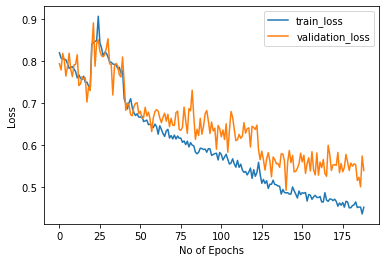

In [50]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    confusion_matrix = torch.zeros(targets_size,targets_size,dtype=torch.int64)

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        for t, p in zip(targets.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        #print(targets.size(),outputs.size())
        #cm_data[targets.item() ,outputs.item()] += 1
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
        
    acc = n_correct / n_total
    #print(targets.item(2))
    #print(outputs.item(2))
    return acc,confusion_matrix

In [52]:
model.eval()
#torch.no_grad()
#os.chdir('/content')
os.chdir('C:/Local Machine/Cassava plant disease detection')

train_acc,train_cm = accuracy(train_dl)
print(f"Train Accuracy : {train_acc*100}% \n")
print(train_cm)

validation_acc,validation_cm = accuracy(val_dl)
print(f"Validation Accuracy : {validation_acc*100}% \n")
print(validation_cm)

test_acc,test_cm = accuracy(test_dl)
print(f"Test Accuracy : {test_acc*100}% \n")
print(test_cm)

Train Accuracy : 86.52% 

tensor([[ 594,   49,    9,   13,   94],
        [  67, 1269,   29,   26,  116],
        [  22,   51, 1273,  143,  136],
        [  48,  228,  291, 8445,  288],
        [ 152,  100,   88,   72, 1397]])
Validation Accuracy : 86.55000000000001% 

tensor([[  79,    4,    3,    1,   15],
        [  11,  204,    4,    7,   15],
        [   2,    1,  197,   14,   26],
        [   8,   28,   35, 1074,   37],
        [  26,   16,    9,    7,  177]])
Test Accuracy : 81.96497612008187% 

tensor([[ 138,   24,    3,    7,   47],
        [  34,  362,    6,   14,   39],
        [   9,   23,  388,   57,   60],
        [  27,   80,   84, 2359,  103],
        [  65,   44,   28,   39,  357]])


In [37]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[ 594,   49,    9,   13,   94],
        [  67, 1269,   29,   26,  116],
        [  22,   51, 1273,  143,  136],
        [  48,  228,  291, 8445,  288],
        [ 152,  100,   88,   72, 1397]])


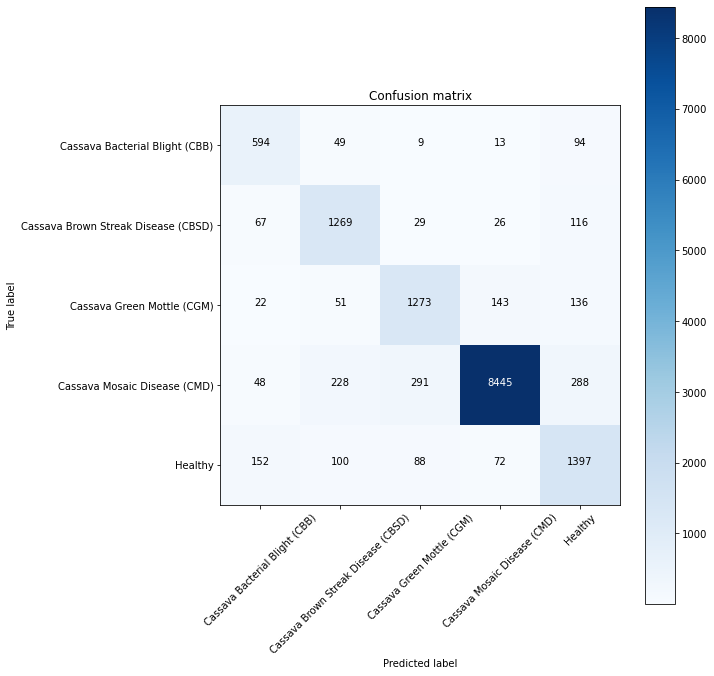

In [53]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(train_cm, label_names)

Confusion matrix, without normalization
tensor([[  79,    4,    3,    1,   15],
        [  11,  204,    4,    7,   15],
        [   2,    1,  197,   14,   26],
        [   8,   28,   35, 1074,   37],
        [  26,   16,    9,    7,  177]])


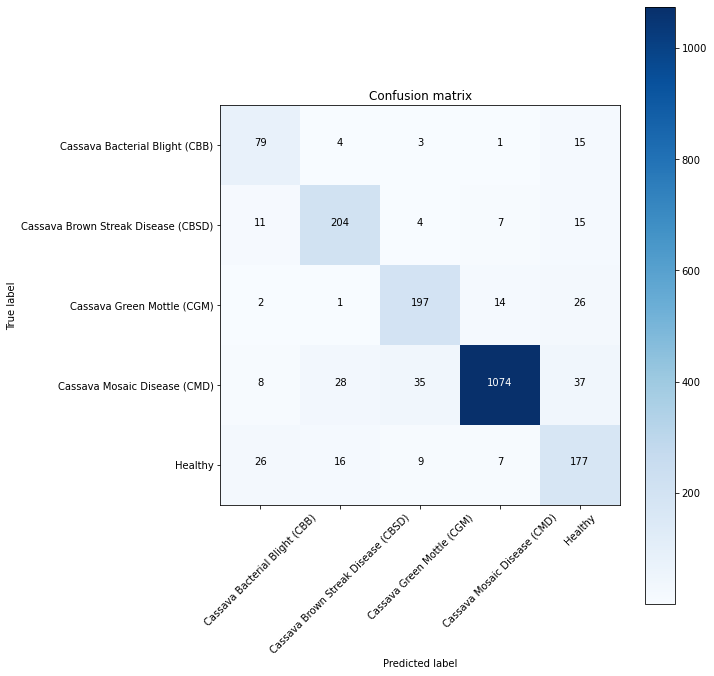

In [54]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(validation_cm, label_names)

Confusion matrix, without normalization
tensor([[ 138,   24,    3,    7,   47],
        [  34,  362,    6,   14,   39],
        [   9,   23,  388,   57,   60],
        [  27,   80,   84, 2359,  103],
        [  65,   44,   28,   39,  357]])


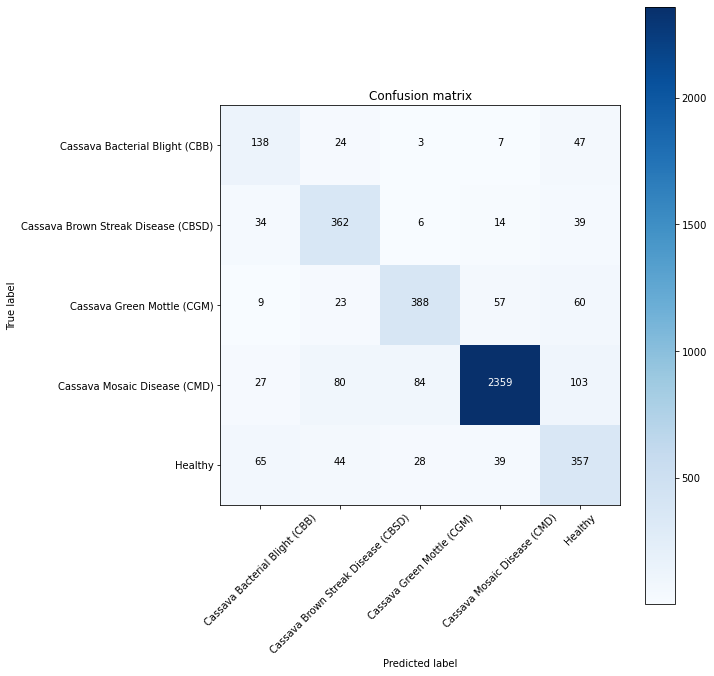

In [55]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(test_cm, label_names)

In [ ]:
def show_img(model):
    model=np.reshape(model.numpy(),[224,224,3]) # For 1D Vector
    
    #If you normalize the image then use Next three-line
    #Otherwise skip that
    mean=np.array([0.485, 0.456, 0.406] )
    std=np.array([0.229, 0.224, 0.225])
    model=(model*std+mean)
    


    #print(model)

    plt.imshow("ABC", model)
    
    #waits for user to press any key
    #(this is necessary to avoid Python kernel form crashing)
    plt.waitKey(0)

    #closing all open windows
    plt.destroyAllWindows()


def copy_missclassified(dataset,loader):
    os.chdir('C:/Local Machine/Cassava plant disease detection')
    for i in label_names:
      for j in label_names:
        if i != j :
          if os.path.isdir(str(i)+'_'+str(j))==False:
            os.mkdir(str(i)+'_'+str(j))
    model.eval()      
    with torch.no_grad():
      for inputs, targets in loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          _, predictions = torch.max(outputs, 1)
          for sampleno in range(inputs.shape[0]):
              if(targets[sampleno]!=predictions[sampleno]):
                    show_img(inputs[sampleno].cpu())
          return predictions
          """
        
        #for t, p in zip(targets.view(-1), predictions.view(-1)):
        print(inputs)
            #confusion_matrix[t.long(), p.long()] += 1   """
                 

In [ ]:
copy_missclassified(pathology_train,val_dl)

In [ ]:
def test(dataset, dataloader):
    net.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0]
            label=batch[1]
            inputs = inputs.to(device, non_blocking=True)
            outputs = net(inputs)
            predictions = torch.argmax(outputs, dim=1)
            for sampleno in range(batch[0].shape[0]):
                if(label[sampleno]!=predictions[sampleno]):
                    print("Actual Lable")
                    print(label[sampleno])
                    print("Predicted Label")
                    print(predictions[sampleno])
                    showimg(inputs[sampleno].cpu())
            return predictions

def show_img(model):
    model=np.reshape(model.numpy(),[28,28]) # For 1D Vector
    
    #If you normalize the image then use Next three-line
    #Otherwise skip that
    mean=np.array([0.485, 0.456, 0.406] )
    std=np.array([0.229, 0.224, 0.225])
    model=(model*std+mean)
    


    #print(model)

    cv2.imshow("ABC", model)
    
    #waits for user to press any key
    #(this is necessary to avoid Python kernel form crashing)
    cv2.waitKey(0)

    #closing all open windows
    cv2.destroyAllWindows()

In [ ]:


original = r'original path where the file is currently stored\file name.file extension'
target = r'target path where the file will be copied\file name.file extension'

shutil.copyfile(original, target)

In [ ]:
copy_missclassified(test_dl)